# Classifying Names with a Character Level RNN

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [6]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print unicodeToAscii(u'Ślusàrski')

Slusarski


In [8]:
import os, glob, codecs

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = codecs.open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]



for filename in glob.glob('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [13]:
print category_lines['Italian'][:5]

[u'Abandonato', u'Abatangelo', u'Abatantuono', u'Abate', u'Abategiovanni']


In [14]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


print lineToTensor('Jones').size()

torch.Size([5, 1, 57])


In [27]:
import torch.nn as nn

# My Version
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.weight_out = nn.Linear(input_size + hidden_size, output_size)
        self.weight_hidden = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, input, hidden):
        the_input = torch.cat((input, hidden), dim=2)
        return torch.nn.functional.softmax(self.weight_out(the_input), dim=2), self.weight_hidden(the_input)
    
rnn = RNN(n_letters, 64, n_categories)
rnn(lineToTensor('J'), torch.zeros(1,1,64))

(tensor([[[0.0571, 0.0518, 0.0612, 0.0546, 0.0532, 0.0581, 0.0627, 0.0554,
           0.0513, 0.0510, 0.0590, 0.0638, 0.0568, 0.0577, 0.0555, 0.0509,
           0.0507, 0.0491]]], grad_fn=<SoftmaxBackward>),
 tensor([[[-0.0879,  0.0399,  0.0020, -0.0146,  0.0015, -0.0099, -0.0033,
            0.0545, -0.0231,  0.1329, -0.0361, -0.0012, -0.0970, -0.0574,
           -0.0929, -0.0480, -0.0101,  0.1279, -0.1375,  0.0591, -0.0970,
            0.1415, -0.0551, -0.1060,  0.0618, -0.0190, -0.0221, -0.0108,
           -0.0795, -0.0192, -0.1088,  0.1067,  0.0265,  0.0216, -0.0767,
            0.0430, -0.0285,  0.0279,  0.0340,  0.0708,  0.0702,  0.0539,
           -0.0307,  0.0638,  0.1554, -0.1050, -0.0071,  0.1243, -0.1495,
           -0.0327, -0.0331,  0.0477,  0.0122, -0.1657, -0.0642, -0.1388,
           -0.1113, -0.0503, -0.1153,  0.0086, -0.1078, -0.0380, -0.0338,
            0.0419]]], grad_fn=<ThAddBackward>))

In [31]:
# Tutorial's version

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
rnn(lineToTensor('J')[0], torch.zeros(1,128))

(tensor([[-2.9247, -2.8500, -2.9228, -2.9234, -2.8103, -3.0213, -2.9825, -2.8406,
          -2.8289, -2.9029, -2.9048, -2.9531, -2.9378, -2.8198, -2.8747, -2.8108,
          -2.8634, -2.8858]], grad_fn=<LogSoftmaxBackward>),
 tensor([[-0.0497,  0.0184,  0.0894, -0.0197, -0.0386, -0.0031, -0.1223,  0.1049,
          -0.0316, -0.0109,  0.0709,  0.1057,  0.0246,  0.0511,  0.0074, -0.0578,
           0.1085, -0.0656,  0.0090, -0.0356, -0.0429,  0.0554,  0.0605,  0.0039,
          -0.0145,  0.0247,  0.0747, -0.0527,  0.0591, -0.0558,  0.0603, -0.0477,
           0.0215, -0.0727, -0.0848,  0.0885, -0.0501,  0.0519, -0.0728, -0.0143,
           0.0426, -0.1236, -0.0052,  0.0526, -0.0928, -0.0306,  0.0377,  0.0276,
          -0.0143,  0.0028, -0.0695, -0.0151,  0.0837, -0.0524,  0.1126,  0.0431,
          -0.0807,  0.0215,  0.0044, -0.0094, -0.0053,  0.0171,  0.0228,  0.0943,
           0.0331,  0.0164,  0.0391,  0.0312,  0.0593,  0.0873,  0.0543, -0.0264,
           0.0723, -0.0623, -0.0482, 

In [138]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print category, '|', line

Polish | Skala
Chinese | Bui
Vietnamese | Vuong
French | Brodeur
Irish | Cathan
French | Petit
Czech | Marik
Russian | Vihrev
Portuguese | Ribeiro
Czech | Svotak


In [91]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-3)

running_loss = 0.0
for t in range(100000):

    hidden = rnn.initHidden()

    rnn.zero_grad()
    category, line, category_tensor, line_tensor = randomTrainingExample()
    # print category, line
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = loss_fn(output, category_tensor)
    loss.backward()
    running_loss += loss.item()
    if t%1000 == 999: 
        print t, loss.item(), running_loss/1000.0
        running_loss = 0
    optimizer.step()

999 3.04575681686 2.68919010448
1999 2.18674468994 2.31357793891
2999 2.16130018234 2.18070190048
3999 2.67323446274 1.99748385394
4999 1.20477795601 1.92362332261
5999 1.70714390278 1.8497427628
6999 1.78350925446 1.7811632489
7999 1.62296867371 1.69328700721
8999 0.818980932236 1.68878353119
9999 1.18015575409 1.64817511129
10999 1.97378778458 1.61126427412
11999 0.934684514999 1.572900195
12999 2.92868351936 1.56417155957
13999 1.1058242321 1.54629578495
14999 0.287118434906 1.55613060319
15999 2.35906481743 1.50508528757
16999 3.53459978104 1.47219792938
17999 0.756918430328 1.48944449139
18999 1.06029224396 1.49170772934
19999 0.480717420578 1.45625909412
20999 0.183713436127 1.38206021702
21999 6.01623296738 1.41265438151
22999 0.156027793884 1.46883927655
23999 0.7529733181 1.39172067142
24999 2.07895231247 1.45736958408
25999 1.32192325592 1.41857603633
26999 1.04804682732 1.36266882408
27999 0.0891051292419 1.37136164773
28999 0.0553116798401 1.34033778906
29999 2.40997862816 

accuracy 0.6027


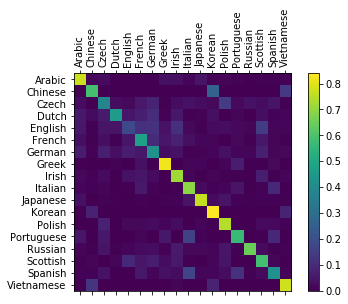

In [92]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000
accuracy_count = 0

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    if guess_i == category_i:
        accuracy_count += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
print "accuracy", float(accuracy_count)/ n_confusion
plt.show();

In [84]:
import torch.nn.functional as F

n_hidden = 128

rnn = torch.nn.RNN(n_letters, n_hidden)
w = torch.randn(n_hidden, n_categories, requires_grad=True)

loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(list(rnn.parameters())+[w], lr=1e-4)

running_loss = 0.0
for t in range(100000):

    hidden = torch.zeros(1,1, n_hidden)

    rnn.zero_grad()
    category, line, category_tensor, line_tensor = randomTrainingExample()
    # print category, line
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i].view(1,1,n_letters), hidden)
        
    output = F.log_softmax(output[0].mm(w), dim = 1)
    loss = loss_fn(output, category_tensor)
    loss.backward()
    running_loss += loss.item()
    if t%1000 == 999: 
        print t, loss.item(), running_loss/1000.
        running_loss = 0
    optimizer.step()

999 1.26362109184 2.78438231421
1999 4.89289951324 2.15886867261
2999 1.49012684822 1.93574161279
3999 0.120291233063 1.80300460148
4999 1.2210021019 1.69897685623
5999 1.27199983597 1.59596140873
6999 0.652854442596 1.57703589153
7999 0.51929473877 1.53807014775
8999 4.75492620468 1.41126478457
9999 1.93855571747 1.43670911705
10999 0.587673187256 1.47217131925
11999 1.19148302078 1.40238417625
12999 2.32868456841 1.44498610377
13999 0.421967983246 1.45664829254
14999 0.303663253784 1.2620152204
15999 0.846525192261 1.26139705014
16999 0.963971614838 1.28117561495
17999 0.71636390686 1.24043897629
18999 0.266483306885 1.28008968043
19999 0.373187541962 1.19922504759
20999 0.599766731262 1.24255457735
21999 0.170603275299 1.27124764729
22999 0.768113136292 1.23030612826
23999 0.40610742569 1.22705670714
24999 0.0988836288452 1.23046308684
25999 0.0488529205322 1.2521069324
26999 0.220487594604 1.17465969014
27999 1.00749349594 1.20781717658
28999 0.252595901489 1.16542831111
29999 0.99

accuracy 0.6559


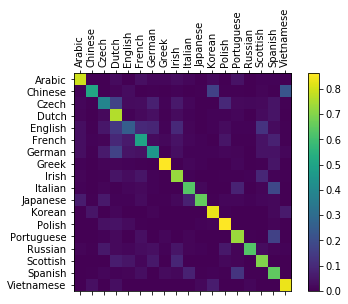

In [88]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000
accuracy_count = 0

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    # print category_i
    return all_categories[category_i], category_i

# Just return an output given a line
def evaluate(line_tensor):
    hidden = hidden = torch.zeros(1,1, n_hidden) #rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i].view(1,1,n_letters), hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    
    output = F.log_softmax(output[0].mm(w), dim = 1)
    # print output.shape
    guess, guess_i = categoryFromOutput(output[0])
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    if guess_i == category_i:
        accuracy_count += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
print "accuracy", float(accuracy_count)/ n_confusion
plt.show();

# Generating Names with a Character level RNN

https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

# Generating Shakespeare

https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb

In [113]:
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = "\n".join(readLines('data/shakespeare.txt'))
file_len = len(file)
print 'file_len =', file_len

file_len = 1098515


In [116]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print random_chunk()


PROSPERO
But are they, Ariel, safe

ARIEL
Not a hair perish'd;
On their sustaining garments not a blemish,
But fresher than before and, as thou badest me,
In troops I have dispersed them 'bout the isl


In [153]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.use_embedding = True
        if self.use_embedding:
            self.encoder = nn.Embedding(input_size, hidden_size)
        else:
            self.encoder = nn.Linear(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        if self.use_embedding:
            input = self.encoder(input.view(1, -1))
        else:
            input_tensor = torch.zeros(self.input_size)
            input_tensor[input] = 1
            input = self.encoder(input_tensor)

        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [155]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
lr = 0.005


import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return torch.tensor(tensor)
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(F.log_softmax(output, dim = 1), target[c].view(1))

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len

decoder = RNN(n_characters, hidden_size, n_characters)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.NLLLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, float(epoch) / n_epochs * 100, loss))
        print evaluate('Wh', 100), '\n' 

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 13s (100 5%) 2.5178]
Whacet ot

ous tof tot matont
Misn ilres at to war tou thinind im, he tosd fo mimeyascot meu,, thisd w 

 27s (200 10%) 2.5533]
Why bouns
Thary thang the dout
Thare thecr,
SeV
Boy thirge to dil this yo me an ory Khim feeNWhe cat f 

 41s (300 15%) 2.2003]
Whud gond there, yom erast an wu mert dean;

DRIS
Condt me wor thuste
Me thor wourt dou whorh heard
Ia 

 55s (400 20%) 2.2782]
Whtt bocwint henere wilt the sit dere hou suepring heme herlnt and thow bell heer, thee
Noto dou fome  

 8s (500 25%) 2.1223]
Whis lands you meid homer wor trair onoy faye sones.
Who kis hack tring in to we ramade.

SET

DUCE
Wh 

 22s (600 30%) 2.5069]
Whser bonenserice I we treald ende le

LICHARDEN
Ros witeds revere'd,
Whall ceale whation teen no whas 

 36s (700 35%) 2.3104]
Whids, cards thild but is herest be or thiegs ats, Rerd ad and me bris whime mut ho thou narest.

PROR 

 50s (800 40%) 2.1413]
Whine a dere
Why to upof ondrep
The gaish, thou suce hel onder and door my is thour

Populating the interactive namespace from numpy and matplotlib


/Users/Dave/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


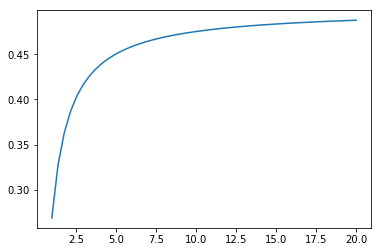

In [117]:
# Temperature stuff

import numpy as np
%pylab inline
x = np.linspace(1,20)
#print x
f = lambda x: np.exp(1./x) /(np.exp(1./x) + np.exp(2./x))
plot(x, f(x));

In [156]:
print evaluate('Th', 200, temperature=1.8) 

The ratio JzompU}'
Stild fmare, joys I w9y whiavera
yeat, nelu
JlAd A
Thex; ekeny ppiciciooss,
Sistlve tuarshi*lly's'stysp
If of Has evern blaute havy wha7 ho; wernswoo. Nom jsoogy guste
xqooo, flombed 


In [158]:
print evaluate('Th', 200, temperature=0.2) 

The love the son the son
The son the soul of the soul he sor the do soul the son the do do son the son of the do my lord and the son
The he more with and the be he word the son of the son the do so me a
